# Knowledge graph link prediction with ComplEx


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/rotationh-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/rotationh-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>


This notebook reproduces the experiments done in the paper that introduced the ComplEx algorith: Complex Embeddings for Simple Link Prediction, Théo Trouillon, Johannes Welbl, Sebastian Riedel, Éric Gaussier and Guillaume Bouchard, ICML 2016. http://jmlr.org/proceedings/papers/v48/trouillon16.pdf

In table 2, the paper reports five metrics measured on the WN18 and FB15K datasets: "raw" MRR (mean reciprocal rank), "filtered" MRR and filtered Hits at {1, 3, 10}. This notebook measures all of these, as well as raw Hits at {1, 3, 10}.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import knowledge_graph

from IPython.display import HTML

## Initialisation

We need to set up our model parameters, like the number of epochs to train for, and the dimension of the embedding vectors we compute for each node and for each edge type.

The evaluation is performed in three steps:

1. Load the data
2. Train a model
3. Evaluate the model

The paper says that it used:
- the AdaGrad optimiser for 1000 epochs with an early stopping criterion evaluated every 50 epochs, but we've found using the Adam optimiser allows for much fewer epochs
- an embedding dimension of 150 or 200, since they had close results
- 10 negative samples (corrupted edges) per positive edge, which gives noticably improved performance on FB15k compared to using 1, and but not for WN18 (the paper evaluated 1, 2, 5 and 10 negative samples)

In [4]:
epochs = 50
embedding_dimension = 32
negative_samples = 5

## WN18RR

The paper uses the WN18RR dataset for validation.

### Load the data

The dataset comes with a defined train, test and validation split, each consisting of subject, relation, object triples. We can load a `StellarGraph` object with all of the triples, as well as the individual splits as Pandas DataFrames, using the `load` method of the `WN18` dataset.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [5]:
wn18 = datasets.WN18RR()
display(HTML(wn18.description))
wn18_graph, wn18_train, wn18_test, wn18_valid = wn18.load()

In [6]:
print(wn18_graph.info())

StellarDiGraph: Directed multigraph
 Nodes: 40943, Edges: 93003

 Node types:
  default: [40943]
    Features: none
    Edge types: default-_also_see->default, default-_derivationally_related_form->default, default-_has_part->default, default-_hypernym->default, default-_instance_hypernym->default, ... (6 more)

 Edge types:
    default-_hypernym->default: [37221]
        Weights: all 1 (default)
    default-_derivationally_related_form->default: [31867]
        Weights: all 1 (default)
    default-_member_meronym->default: [7928]
        Weights: all 1 (default)
    default-_has_part->default: [5142]
        Weights: all 1 (default)
    default-_synset_domain_topic_of->default: [3335]
        Weights: all 1 (default)
    default-_instance_hypernym->default: [3150]
        Weights: all 1 (default)
    default-_also_see->default: [1396]
        Weights: all 1 (default)
    default-_verb_group->default: [1220]
        Weights: all 1 (default)
    default-_member_of_domain_region->default

### Train a model

The ComplEx algorithm consists of some embedding layers and a scoring layer, but the `ComplEx` object means these details are invisible to us. The `ComplEx` model consumes "knowledge-graph triples", which can be produced in the appropriate format using `KGTripleGenerator`.

In [7]:
wn18_gen = KGTripleGenerator(wn18_graph, batch_size=500)

wn18_complex = knowledge_graph.RotationHE(
    wn18_gen, embedding_dimension=embedding_dimension,
)

wn18_inp, wn18_out = wn18_complex.in_out_tensors()

wn18_model = Model(inputs=wn18_inp, outputs=wn18_out)

wn18_model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

Inputs for training are produced by calling the `KGTripleGenerator.flow` method, this takes a dataframe with `source`, `label` and `target` columns, where each row is a true edge in the knowledge graph.  The `negative_samples` parameter controls how many random edges are created for each positive edge to use as negative examples for training.

In [8]:
wn18_train_gen = wn18_gen.flow(
    wn18_train, negative_samples=negative_samples, shuffle=True
)
wn18_valid_gen = wn18_gen.flow(wn18_valid, negative_samples=negative_samples)

In [9]:
wn18_es = callbacks.EarlyStopping(monitor="val_loss", patience=30)
wn18_history = wn18_model.fit(
    wn18_train_gen, validation_data=wn18_valid_gen, epochs=epochs, callbacks=[wn18_es]
)

  ['...']
  ['...']
Train for 174 steps, validate for 7 steps
Epoch 1/50
174/174 [==============================] - 7s 38ms/step - loss: 0.4497 - binary_accuracy: 0.8333 - val_loss: 0.4377 - val_binary_accuracy: 0.8333
Epoch 2/50
174/174 [==============================] - 5s 31ms/step - loss: 0.4083 - binary_accuracy: 0.8333 - val_loss: 0.4272 - val_binary_accuracy: 0.8333
Epoch 3/50
174/174 [==============================] - 5s 30ms/step - loss: 0.3733 - binary_accuracy: 0.8333 - val_loss: 0.4244 - val_binary_accuracy: 0.8333
Epoch 4/50
174/174 [==============================] - 5s 30ms/step - loss: 0.3411 - binary_accuracy: 0.8333 - val_loss: 0.4231 - val_binary_accuracy: 0.8334
Epoch 5/50
174/174 [==============================] - 5s 31ms/step - loss: 0.3133 - binary_accuracy: 0.8333 - val_loss: 0.4262 - val_binary_accuracy: 0.8334
Epoch 6/50
174/174 [==============================] - 5s 31ms/step - loss: 0.2904 - binary_accuracy: 0.8335 - val_loss: 0.4290 - val_binary_accuracy: 0.8

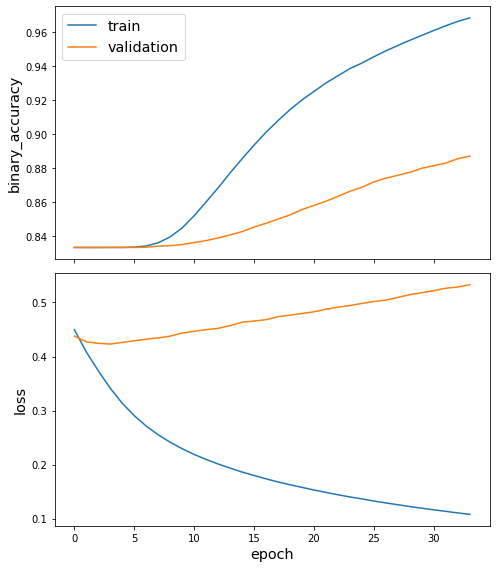

In [10]:
utils.plot_history(wn18_history)

### Evaluate the model

We've now trained a model, so we can apply the evaluation procedure from the paper to it. This is done by taking each test edge `E = (s, r, o)`, and scoring it against all mutations `(s, r, n)` and `(n, r, o)` for every node `n` in the graph, that is, doing a prediction for every one of these edges similar to `E`. The "raw" rank is the number of mutated edges that have a higher predicted score than the true `E`.

In [11]:
wn18_raw_ranks, wn18_filtered_ranks = wn18_complex.rank_edges_against_all_nodes(
    wn18_gen.flow(wn18_test), wn18_graph
)

In [12]:
# helper function to compute metrics from a dictionary of name -> array of ranks
def results_as_dataframe(name_to_results):
    return pd.DataFrame(
        name_to_results.values(),
        columns=["mrr", "hits at 1", "hits at 3", "hits at 10"],
        index=name_to_results.keys(),
    )


def summarise(name_to_ranks):
    return results_as_dataframe(
        {
            name: (
                np.mean(1 / ranks),
                np.mean(ranks <= 1),
                np.mean(ranks < 3),
                np.mean(ranks <= 10),
            )
            for name, ranks in name_to_ranks.items()
        }
    )

In [13]:
summarise({"raw": wn18_raw_ranks, "filtered": wn18_filtered_ranks})

,mrr,hits at 1,hits at 3,hits at 10
raw,0.598731,0.4814,0.6065,0.8192
filtered,0.940128,0.9299,0.9451,0.9546


For comparison, Table 2 in the paper gives the following results for WN18 (`NaN` denotes values the paper does not include). All of the numbers are similar:

In [14]:
results_as_dataframe(
    {"raw": (0.587, None, None, None), "filtered": (0.941, 0.936, 0.945, 0.947)}
)

,mrr,hits at 1,hits at 3,hits at 10
raw,0.587,NaN,NaN,NaN
filtered,0.941,0.936,0.945,0.947


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/rotationh-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/rotationh-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>